In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013.csv


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential

from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
import random


np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)  # For TensorFlow/Keras


In [3]:
data = pd.read_csv('/kaggle/input/fer2013.csv')

In [4]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
x_data = data['pixels']
y_data = data['emotion']

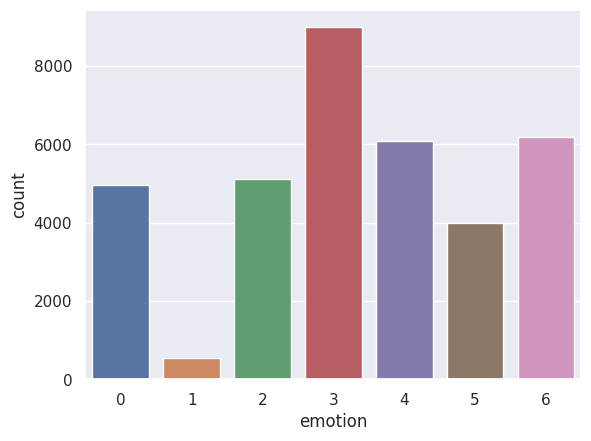

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [7]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [8]:
y_data.value_counts()

emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64

In [9]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    29 27 31 35 26 63 81 71 88 91 114 146 141 122 ...
62919    122 122 125 58 7 12 16 25 34 45 43 43 43 47 51...
62920    191 192 191 190 186 186 187 187 174 164 129 84...
62921    25 17 14 17 10 8 16 21 20 14 16 28 37 44 56 71...
62922    40 29 7 11 12 29 54 14 1 5 0 1 1 1 0 0 0 0 0 0...
Length: 62923, dtype: object

In [10]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [11]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [12]:
from tensorflow.keras.utils import to_categorical
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=np.random.randint(0, 10000))
val_size = 15 / 85  # 15% of remaining 85%
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_size, random_state=np.random.randint(0, 10000))

    # One-hot encode labels
y_train = to_categorical(y_train, 7)
y_val = to_categorical(y_val, 7)
y_test = to_categorical(y_test, 7)

In [13]:
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42) 

# Assuming x_data and y_data are already loaded

# Define the function to build your model
def build_net(optim):
    net = Sequential(name='DCNN')
    
    # Add layers to the model
    net.add(Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
    net.add(BatchNormalization())
    net.add(Conv2D(64, (5, 5), activation='elu', padding='same', kernel_initializer='he_normal'))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2, 2)))
    net.add(Dropout(0.4))

    net.add(Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    net.add(BatchNormalization())
    net.add(Conv2D(128, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2, 2)))
    net.add(Dropout(0.4))

    net.add(Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    net.add(BatchNormalization())
    net.add(Conv2D(256, (3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(pool_size=(2, 2)))
    net.add(Dropout(0.5))

    net.add(Flatten())
    net.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    net.add(BatchNormalization())
    net.add(Dropout(0.6))
    net.add(Dense(7, activation='softmax'))

    net.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return net


# Define optimizers
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(learning_rate=0.001),
]
model = build_net(optims[1])

    # Train the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

    # Print test accuracy for this iteration
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


I0000 00:00:1730806092.342936     109 service.cc:145] XLA service 0x7fd2b80227d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730806092.343004     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  13/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.1510 - loss: 3.3442

I0000 00:00:1730806102.663492     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.2658 - loss: 2.1503 - val_accuracy: 0.4777 - val_loss: 1.3888
Epoch 2/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.4665 - loss: 1.4115 - val_accuracy: 0.5525 - val_loss: 1.2042
Epoch 3/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5464 - loss: 1.2099 - val_accuracy: 0.6180 - val_loss: 1.0186
Epoch 4/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5980 - loss: 1.0834 - val_accuracy: 0.6400 - val_loss: 0.9503
Epoch 5/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6298 - loss: 0.9905 - val_accuracy: 0.6588 - val_loss: 0.9134
Epoch 6/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6643 - loss: 0.9111 - val_accuracy: 0.6880 - val_loss: 0.8356
Epoch 7/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6876 - loss: 0.8450 - val_accuracy: 0.7182 - val_loss: 0.7794
Epoch 8/100
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7120 - los

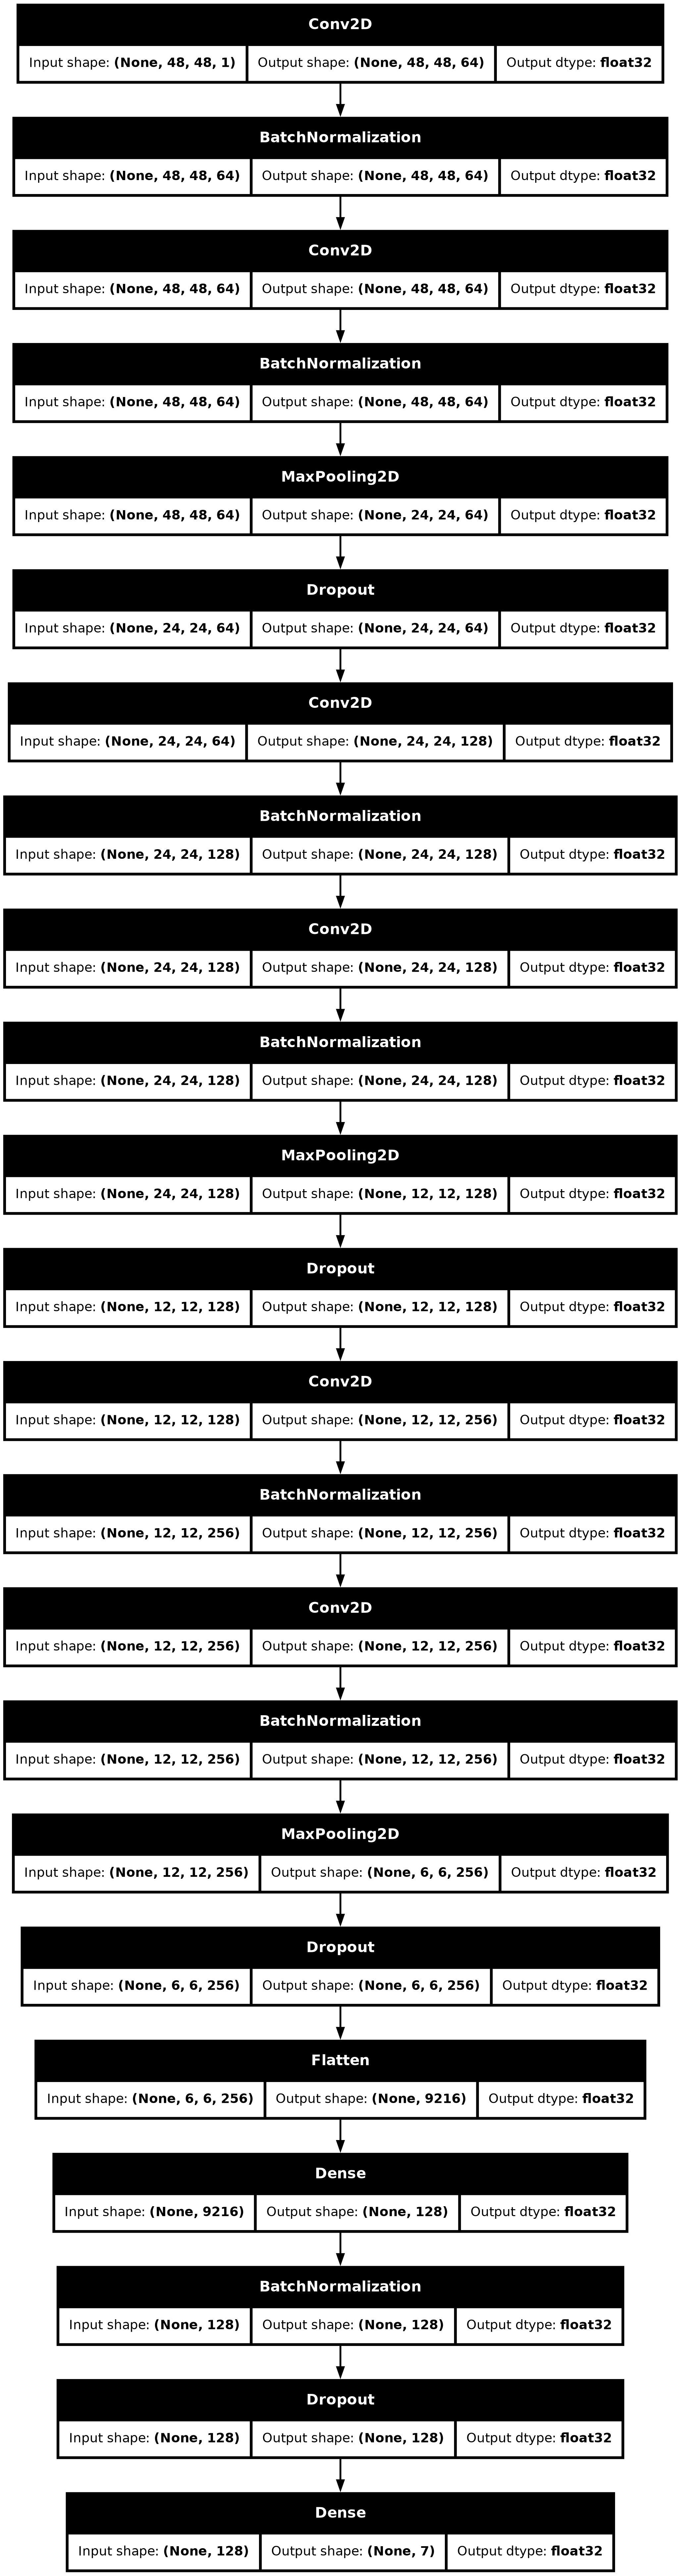

In [14]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)


295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


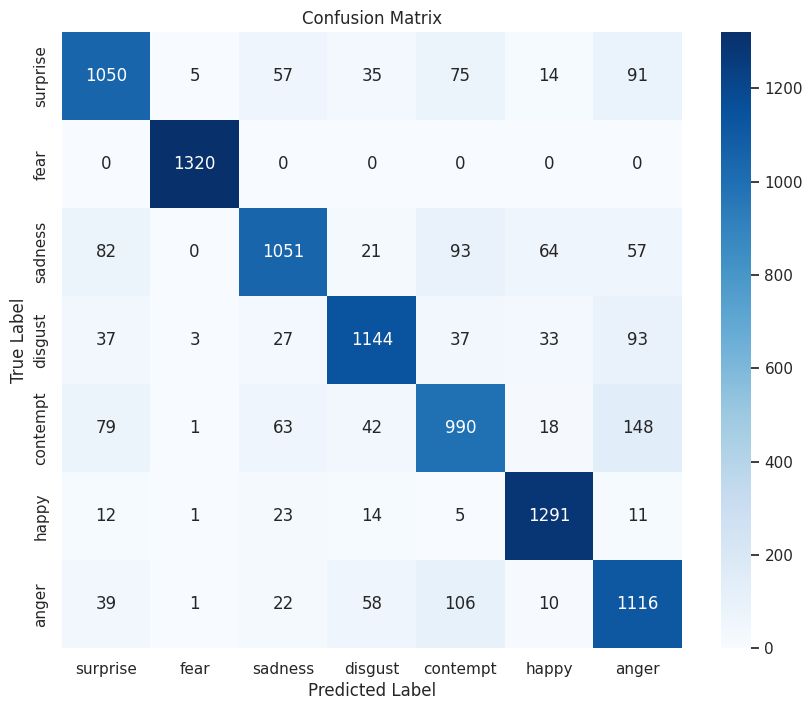

Classification Report:
               precision    recall  f1-score   support

    surprise       0.81      0.79      0.80      1327
        fear       0.99      1.00      1.00      1320
     sadness       0.85      0.77      0.81      1368
     disgust       0.87      0.83      0.85      1374
    contempt       0.76      0.74      0.75      1341
       happy       0.90      0.95      0.93      1357
       anger       0.74      0.83      0.78      1352

    accuracy                           0.84      9439
   macro avg       0.84      0.84      0.84      9439
weighted avg       0.84      0.84      0.84      9439



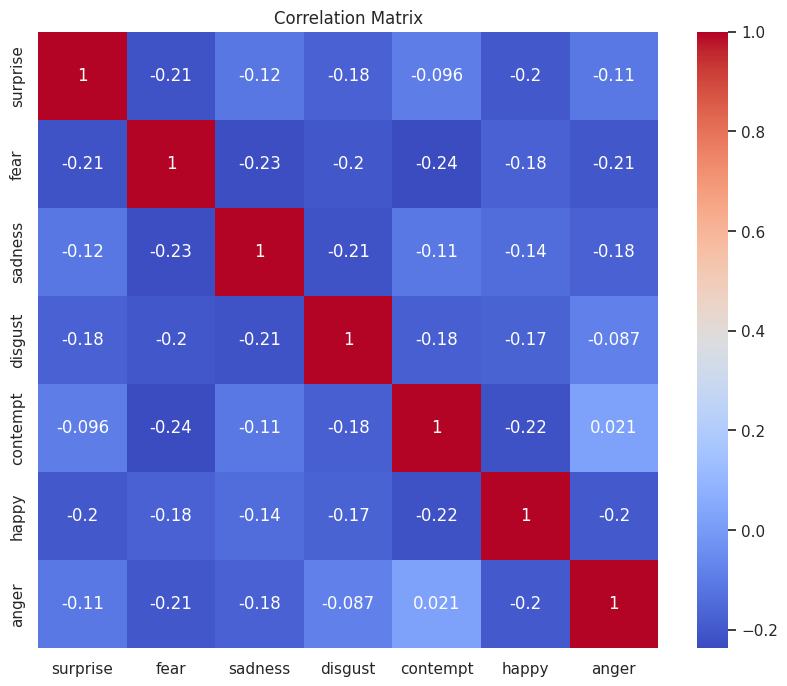

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Extract true labels from the dataset
true_classes = np.argmax(y_test, axis=1)

# Get predicted labels from the model
predicted_classes = np.argmax(model.predict(x_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
target_names = ['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=target_names)
print('Classification Report:\n', report)

# Normalized Confusion Matrix for Correlation
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
correlation_matrix = np.corrcoef(cm_normalized)

# Plot Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=target_names, yticklabels=target_names)
plt.title('Correlation Matrix')
plt.show()


In [16]:
model.save('1_84_fer2013.keras')